In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import tarfile
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [4]:
# Check GPU availability
if torch.cuda.is_available():
  device = torch.device("cuda")
  print("You are on GPU !")
else:
  print('Change the runtime to GPU or continue with CPU, but this should slow down your trainings')
  device = torch.device("cpu")

You are on GPU !


In [5]:
# Using tarfile to create np arrays
def extract_files(dataset):
    tar = tarfile.open(dataset+'.tar', 'r')
    names = tar.getmembers()[:]
    images = [tar.extractfile(name) for name in names]
    return np.array([np.array(Image.open(image)) for image in images])

In [6]:
X_train = extract_files('TRAIN')
X_test = extract_files('TEST')
y_train = np.load('y_train.npy').reshape(-1, 1)
X_train, X_train_val, y_train, y_train_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print("Train data : " ,X_train.shape)
print("Train labels" , y_train.shape)
print("Test data : " ,X_test.shape)

Train data :  (16000, 64, 64, 3)
Train labels (16000, 1)
Test data :  (7000, 64, 64, 3)


In [7]:
# Convert the uint8 array to PIL Images
def numpy_array_to_pil(images_array):
    pil_images = []
    for img_array in images_array:
        pil_image = Image.fromarray(np.uint8(img_array))
        pil_images.append(pil_image)
    return pil_images

X_train_pil = numpy_array_to_pil(X_train[:])
X_train_val_pil = numpy_array_to_pil(X_train_val[:])
X_test_pil = numpy_array_to_pil(X_test[:])

In [8]:
# one hot encode the labels
enc = OneHotEncoder()
y_train = enc.fit_transform(y_train).toarray()
y_train_val = enc.fit_transform(y_train_val).toarray()
# Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_pil, y_train, test_size=0.2, random_state=42)

# Define the transformations
transformations = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.Resize((224, 224)),  # ResNet input size
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [7]:
# Create the datasets
train_set = TensorDataset(torch.stack([transformations(i) for i in X_train]), torch.Tensor(y_train))
val_set = TensorDataset(torch.stack([transformations(i) for i in X_val]), torch.Tensor(y_val))
test_set = TensorDataset(torch.stack([transformations(i) for i in X_test_pil]))

# Create the dataloaders
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

In [9]:
from torchvision import models

# Define a ResNet-based model adapted for 10 classes
class AdaptedResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AdaptedResNet, self).__init__()
        # Load a pretrained ResNet model (e.g., ResNet-50)
        self.resnet = models.resnet50(pretrained=True)
        # Replace the final classification layer with a new one for 10 classes
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

C:\Users\mouta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\mouta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\mouta/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100.0%


Epoch: 1/80..  Training Loss: 0.901..  Training Accuracy: 75.92%..  Validation Loss: 0.293..  Validation Accuracy: 92.45%
Epoch: 2/80..  Training Loss: 0.234..  Training Accuracy: 93.22%..  Validation Loss: 0.171..  Validation Accuracy: 94.80%
Epoch: 3/80..  Training Loss: 0.129..  Training Accuracy: 96.47%..  Validation Loss: 0.135..  Validation Accuracy: 95.92%
Epoch: 4/80..  Training Loss: 0.078..  Training Accuracy: 97.97%..  Validation Loss: 0.131..  Validation Accuracy: 95.80%
Epoch: 5/80..  Training Loss: 0.052..  Training Accuracy: 98.80%..  Validation Loss: 0.125..  Validation Accuracy: 95.90%
Epoch: 6/80..  Training Loss: 0.034..  Training Accuracy: 99.31%..  Validation Loss: 0.125..  Validation Accuracy: 95.97%
Epoch: 7/80..  Training Loss: 0.024..  Training Accuracy: 99.62%..  Validation Loss: 0.126..  Validation Accuracy: 95.92%
Epoch: 8/80..  Training Loss: 0.019..  Training Accuracy: 99.65%..  Validation Loss: 0.127..  Validation Accuracy: 95.92%
Epoch: 9/80..  Training 

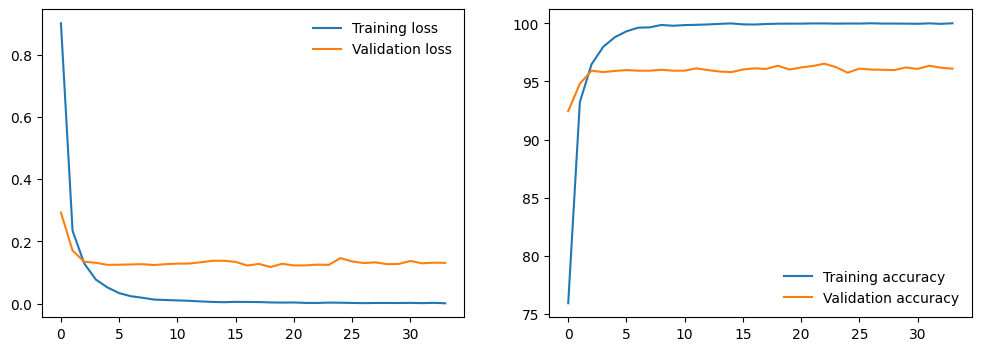

In [16]:
import matplotlib.pyplot as plt

# Define the optimizer and the loss function
model = AdaptedResNet().to(device)
learning_rate = 0.00001
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0001, amsgrad=True)
criterion = nn.CrossEntropyLoss()

# Train the model
epochs = 80
train_losses, val_losses = [], []
train_accs, val_accs = [], []
best_val_loss = float('inf')
patience = 15  # Number of epochs to wait if validation loss does not improve
wait = 0

for epoch in range(epochs):
    train_loss = 0
    val_loss = 0
    correct_train = 0
    total_train = 0
    correct_val = 0
    total_val = 0
    model.train()
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        log_ps = model(images)
        loss = criterion(log_ps, torch.argmax(labels, 1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(log_ps, 1)
        total_train += labels.size(0)
        correct_train += (predicted == torch.argmax(labels, 1)).sum().item()
    
    else:
        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                log_ps = model(images)
                loss = criterion(log_ps, torch.argmax(labels, 1))
                val_loss += loss.item()
                _, predicted = torch.max(log_ps, 1)
                total_val += labels.size(0)
                correct_val += (predicted == torch.argmax(labels, 1)).sum().item()
        
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        train_acc = 100 * correct_train / total_train
        val_acc = 100 * correct_val / total_val
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        print("Epoch: {}/{}.. ".format(epoch + 1, epochs),
              "Training Loss: {:.3f}.. ".format(train_loss / len(train_loader)),
              "Training Accuracy: {:.2f}%.. ".format(train_acc),
              "Validation Loss: {:.3f}.. ".format(val_loss / len(val_loader)),
              "Validation Accuracy: {:.2f}%".format(val_acc))
        
        if val_loss < best_val_loss:
            wait = 0
            best_val_loss = val_loss
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping at epoch {epoch + 1} as validation loss didn't improve.")
                break

# Plot the training and validation losses and accuracies
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training accuracy')
plt.plot(val_accs, label='Validation accuracy')
plt.legend(frameon=False)
plt.show()

In [17]:
# Save the model
torch.save(model.state_dict(), "model_resnet_pretrained_lr_" + str(learning_rate) + ".pt")

In [10]:
# Test on X_train_val

# Load the model
learning_rate = 0.00001
model = AdaptedResNet().to(device)
model.load_state_dict(torch.load("model_resnet_pretrained_lr_" + str(learning_rate) + ".pt"))

test_loader = DataLoader(TensorDataset(torch.stack([transformations(i) for i in X_train_val_pil])), batch_size=64, shuffle=False)

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    y_pred = []
    for images in test_loader:
        images = images[0].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.append(predicted.cpu().numpy())
    y_pred = np.concatenate(y_pred)
    print('Accuracy of the network on the train images: %d %%' % (100 * np.mean(y_pred == torch.argmax(torch.Tensor(y_train_val), 1).numpy())))

C:\Users\mouta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\mouta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Accuracy of the network on the train images: 96 %


In [11]:
# save y_pred
np.save("y_pred_resnet_pretrained_lr_" + str(learning_rate) + ".npy", y_pred)

In [21]:
# load y_pred
y_pred = np.load("y_pred_resnet_pretrained_lr_" + str(learning_rate) + ".npy")

In [22]:
labels = enc.categories_[0]
print(labels)

['AnnualCrop' 'Forest' 'HerbaceousVegetation' 'Highway' 'Industrial'
 'Pasture' 'PermanentCrop' 'Residential' 'River' 'SeaLake']


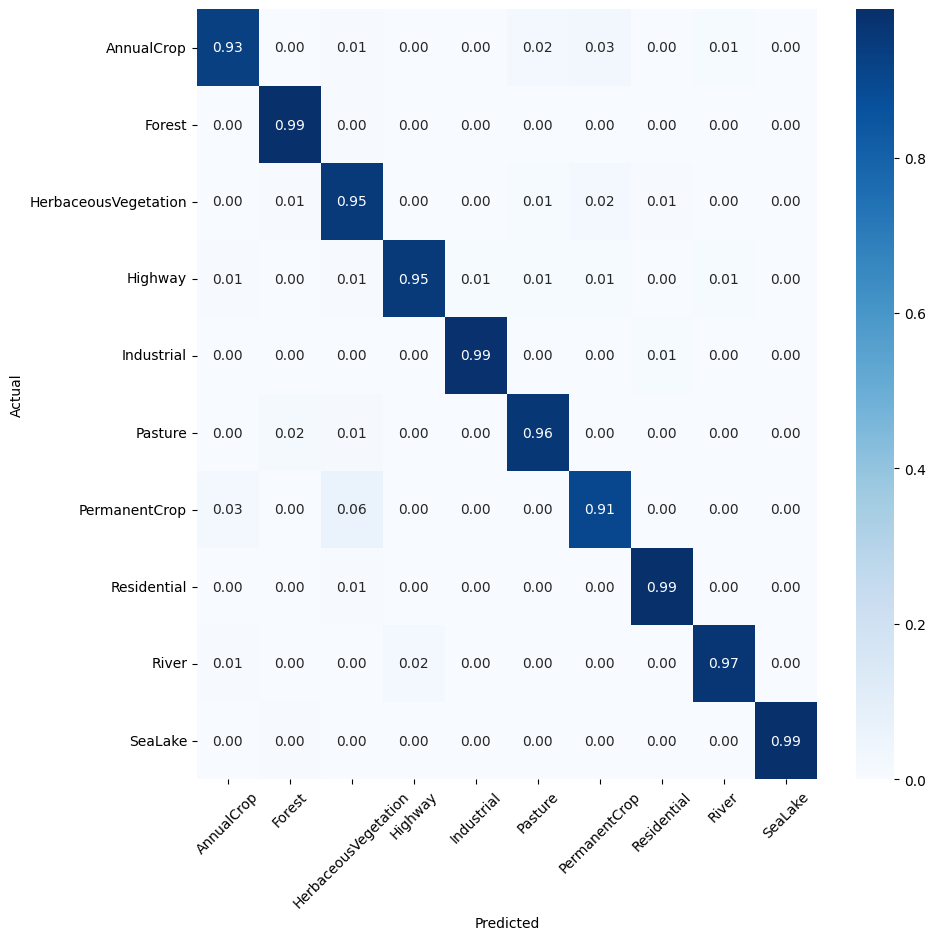

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute the confusion matrix
cm = confusion_matrix(torch.argmax(torch.Tensor(y_train_val), 1).numpy(), y_pred)

# Normalize the confusion matrix
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Define the class labels
class_labels = enc.categories_[0]

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.xticks(rotation=45)
plt.show()

In [30]:
# load y_test
y_test = np.load('y_test.npy').reshape(-1, 1)
print("Test labels" , y_test.shape)
print(y_test[:10])

# load predictions
y_pred = np.load('predictions.npy')
print("Predictions" , y_pred.shape)
print(y_pred[:10])

Test labels (7000, 1)
[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]]
Predictions (7000, 1)
[['Forest']
 ['Forest']
 ['Forest']
 ['Forest']
 ['Forest']
 ['Forest']
 ['Forest']
 ['Forest']
 ['AnnualCrop']
 ['Forest']]


In [26]:
# Load the model
learning_rate = 0.00001
model = AdaptedResNet().to(device)
model.load_state_dict(torch.load("model_resnet_pretrained_lr_" + str(learning_rate) + ".pt"))

# Get the predictions for the test data
model.eval()
preds = []
pred_labels = []
with torch.no_grad():
    for images in test_loader:
        images = images[0].to(device)
        log_ps = model(images)
        pred = log_ps
        preds.append(pred.cpu().numpy())
        pred_labels.append(enc.inverse_transform(pred.cpu().numpy()))
preds = np.concatenate(preds)
pred_labels = np.concatenate(pred_labels)

C:\Users\mouta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\mouta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [27]:
print("Predictions" , preds.shape)
print(preds[:10])
print(pred_labels[:10])

Predictions (7000, 10)
[[-0.541513   -0.49954242 -1.9217368  -0.11721841 -1.5120753  11.21968
  -2.676211   -2.520034   -0.5979061  -3.1188014 ]
 [-1.5393827  -1.5960553  -1.5957708  -0.31413028  7.7409744  -0.6543786
  -1.457439   -0.62778336  0.13957201 -2.032118  ]
 [-0.9762797  -1.0500648  -1.6003606  -0.8623161  -1.8933746   0.14985082
  10.350905   -1.8177705  -1.8591795  -2.206637  ]
 [-1.0146834  10.665585   -1.5015142  -1.200254   -1.7712686  -0.78173107
  -1.4773135  -2.2393656  -1.2642361  -2.1627305 ]
 [-2.0623763  -1.933692   -0.67731476 -0.50439537 -1.8114337  -2.2698
  -2.0028102  -1.7904091   9.160508   -1.7312677 ]
 [-1.6002964  -1.529083   -1.7913694  -0.6850178  -1.7305744  -1.7565675
  -1.2151452  11.1762     -1.6932105  -2.0334065 ]
 [-2.0452204  -0.26972955 -2.3557832  -1.9123721  -0.811303   -1.5953883
  -0.73004466 11.051656   -2.5366578  -1.2488685 ]
 [-1.3216958  -1.9226366  -0.63339543 -0.12039337 10.278068   -1.3211966
  -1.2862867  -2.6063073  -1.1777725  -

In [28]:
# Save the predictions as a npy file
np.save('predictions_resnet_pretrained_lr_' + str(learning_rate) + '.npy', pred_labels)

In [33]:
print(y_pred.shape)
print(pred_labels.shape)

print(y_pred[:10])
print(pred_labels[:10])

(7000, 1)
(7000, 1)
[['Forest']
 ['Forest']
 ['Forest']
 ['Forest']
 ['Forest']
 ['Forest']
 ['Forest']
 ['Forest']
 ['AnnualCrop']
 ['Forest']]
[['Pasture']
 ['Industrial']
 ['PermanentCrop']
 ['Forest']
 ['River']
 ['Residential']
 ['Residential']
 ['Industrial']
 ['AnnualCrop']
 ['HerbaceousVegetation']]


In [7]:
# Function to create a submission file
def create_submission(name, predictions):
    assert predictions.shape == (7000, 1), f"Wrong shape for your prediction file : {predictions.shape} instead of (7000, 1)"
    with open("predictions__" + name + ".npy", "wb") as f:
      np.save(f, predictions)
    print("File predictions.npy created !")

In [8]:
# import predictions
learning_rate = 0.00001
predictions = np.load('predictions_resnet_pretrained_lr_' + str(learning_rate) + '.npy')

In [9]:
# Create a submission using the provided function
NAME = "MOUTAHIR"
from datetime import datetime
# Get the current date
current_date = datetime.now()
# Format the date as MM_DD_YY
formatted_date = current_date.strftime("%m_%d_%y")

create_submission(f"{NAME}_{formatted_date}",predictions)

File predictions.npy created !
